<a href="https://colab.research.google.com/github/BuiDaoGiaHuy/something/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [28]:
import cv2

import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

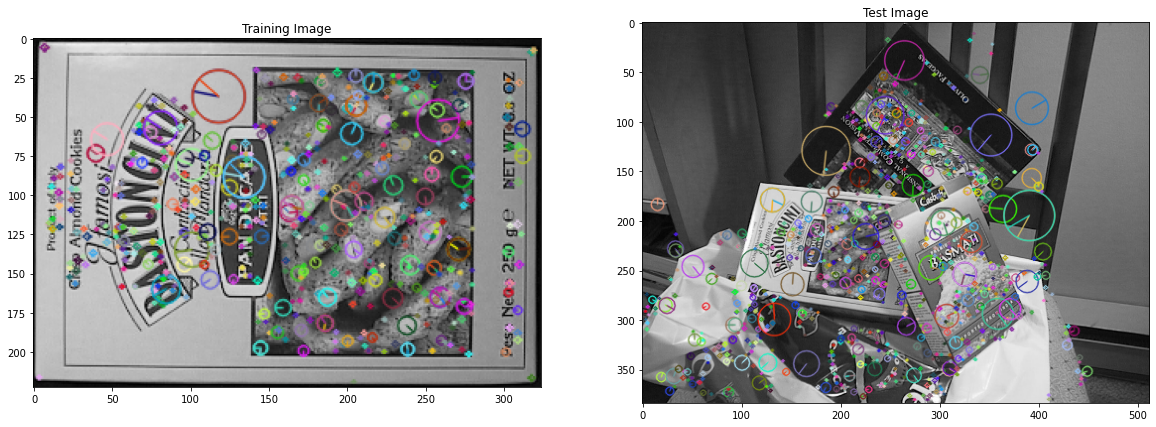

In [4]:
imageTrain = '/content/box.png'
imageTest = '/content/box_in_scene.png'

img1 = cv.imread(imageTrain) # trainImage
img2 = cv.imread(imageTest) # test

# Detect keypoints using SIFT feature
sift = cv.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# Display traning image and testing image
vis_point1 = cv.drawKeypoints(img1,kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_point2 = cv.drawKeypoints(img2,kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(vis_point1)
plots[1].set_title("Test Image")
plots[1].imshow(vis_point2)

plt.show()

In [5]:

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)

In [6]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2) # danh sach toa do cac diem anh train (duoc danh gia la good)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2) # danh sach toa do cac diem anh test (tuong ung connect voi train)

In [66]:
def calc_H(p,p_):
  #|x1 y1 1 0  0  0 -x1X1 -y1X1| |a| |X1|
  #|x2 y2 1 0  0  0 -x2X2 -y2X2| |b| |X2|
  #|x3 y3 1 0  0  0 -x3X3 -y3X3| |c| |X3|
  #|x4 y4 1 0  0  0 -x4X4 -y4X4|@|d|=|X4|
  #|0  0  0 x1 y1 1 -x1Y1 -y1Y1| |e| |X5|
  #|0  0  0 x2 y2 1 -x2Y2 -y2Y2| |f| |X6|
  #|0  0  0 x3 y3 1 -x3Y3 -y3Y3| |g| |X7|
  #|0  0  0 x4 y4 1 -x4Y4 -y4Y4| |h| |X8|
  matrix=np.zeros((1,8))
  X_Y_vector=np.zeros(1)
  for i in range(4):
      #[x y 1 0 0 0 -xX -yX]
      x=p[i][0]
      y=p[i][1]
      X=p_[i][0]
      row=np.array([[x,y,1,0,0,0,-x*X,-y*X]])
      matrix=np.concatenate((matrix,row))
      X_Y_vector=np.append(X_Y_vector,X)
  for i in range(4):
      #[0 0 0 x y 1 -xY -yY]
      x=p[i][0]
      y=p[i][1]
      Y=p_[i][1]
      row=np.array([[0,0,0,x,y,1,-x*Y,-y*Y]])
      matrix=np.concatenate((matrix,row))
      X_Y_vector=np.append(X_Y_vector,Y)
  X_Y_vector=X_Y_vector[1:].reshape(-1,1)
  try:
    vector_H=np.linalg.inv(matrix[1:])@X_Y_vector
    vector_H=np.concatenate((vector_H,np.ones((1,1))))
    H_matrix=vector_H.reshape(3,3)
    return H_matrix
  except:
    return None

In [82]:
def Hmatrix_ransac(src_pts,dst_pts,e,l):
    best_Hmatrix=None
    best_set=None
    largest_num_points=0
    while l:
      list_4pts=random.sample(range(0,len(src_pts)),4)
      list_4src=[src_pts[i,0] for i in list_4pts]
      list_4dst=[dst_pts[i,0] for i in list_4pts]
      matrix=calc_H(list_4src,list_4dst)
      if type(matrix)==type(None): continue
      temp_set=[]
      for i in range(len(src_pts)):
          src_pt=np.append(src_pts[i,0],1).reshape(3,1)
          H_pt=matrix@src_pt
          w=H_pt[2]
          H_pt=(H_pt/w)[:2].reshape(1,2)
          dst_pt=dst_pts[i,0]
          distance=np.linalg.norm(H_pt-dst_pt)
          if distance<=e:
            temp_set.append([src_pts[i,0],dst_pt])
      if len(temp_set)>largest_num_points:
        largest_num_points=len(temp_set)
        best_Hmatrix=matrix
        best_set=temp_set
      l-=1
    return best_Hmatrix,best_set

In [96]:
H_matrix, new_set=Hmatrix_ransac(src_pts,dst_pts,2,500)
print(H_matrix)

[[ 4.43317516e-01 -1.68234185e-01  1.18662943e+02]
 [ 6.28954562e-03  4.03988833e-01  1.59822755e+02]
 [-2.48521366e-04 -3.66829017e-04  1.00000000e+00]]


In [97]:
H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)   
print(H[0])

[[ 4.40108574e-01 -1.60923582e-01  1.18827069e+02]
 [-1.41902723e-03  4.07434564e-01  1.60994111e+02]
 [-2.56415314e-04 -3.37649872e-04  1.00000000e+00]]
